In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Found at: /home/eecs/holly_jackson/dfd/MobileDepth/aligned-focus-stack/Aligned/Figure5/bottles
Focal depths: [8.1927140e+06 7.9211035e+06 6.9956440e+06 6.8852895e+06 4.9922190e+06
 2.0296646e+03 1.7829900e+02 2.4502525e+02 1.0868426e+02 7.8987030e+01
 6.1182655e+01 4.9028160e+01 4.3264957e+01 3.6864040e+01 3.1909075e+01
 2.5983974e+01 2.3566650e+01 2.1700497e+01 2.0030046e+01 1.8571783e+01
 1.7384253e+01 1.6516647e+01 1.5631887e+01 1.5000034e+01 1.4052573e+01
 1.3084701e+01 1.2514304e+01 1.1700458e+01 1.1261277e+01 1.0832749e+01
 1.0000000e+01]
Apertures: 21.738576
Focal length: 2.0
(31, 360, 640, 3)


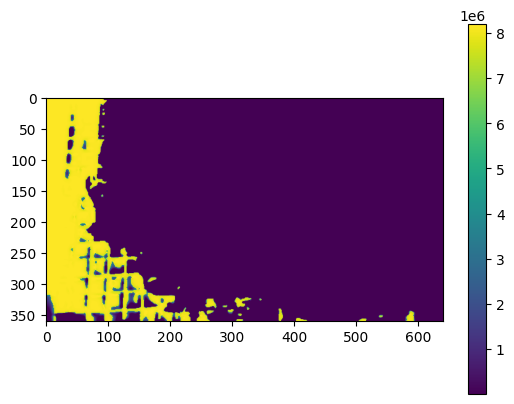

9.911721 8192714.0
(31, 344, 204, 3) 9.961108 255.0
31 344 204
float32 float32
Dpt result range: 9.911721 - 8192714.0


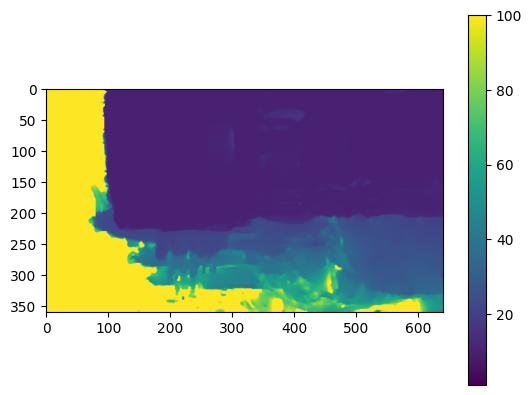

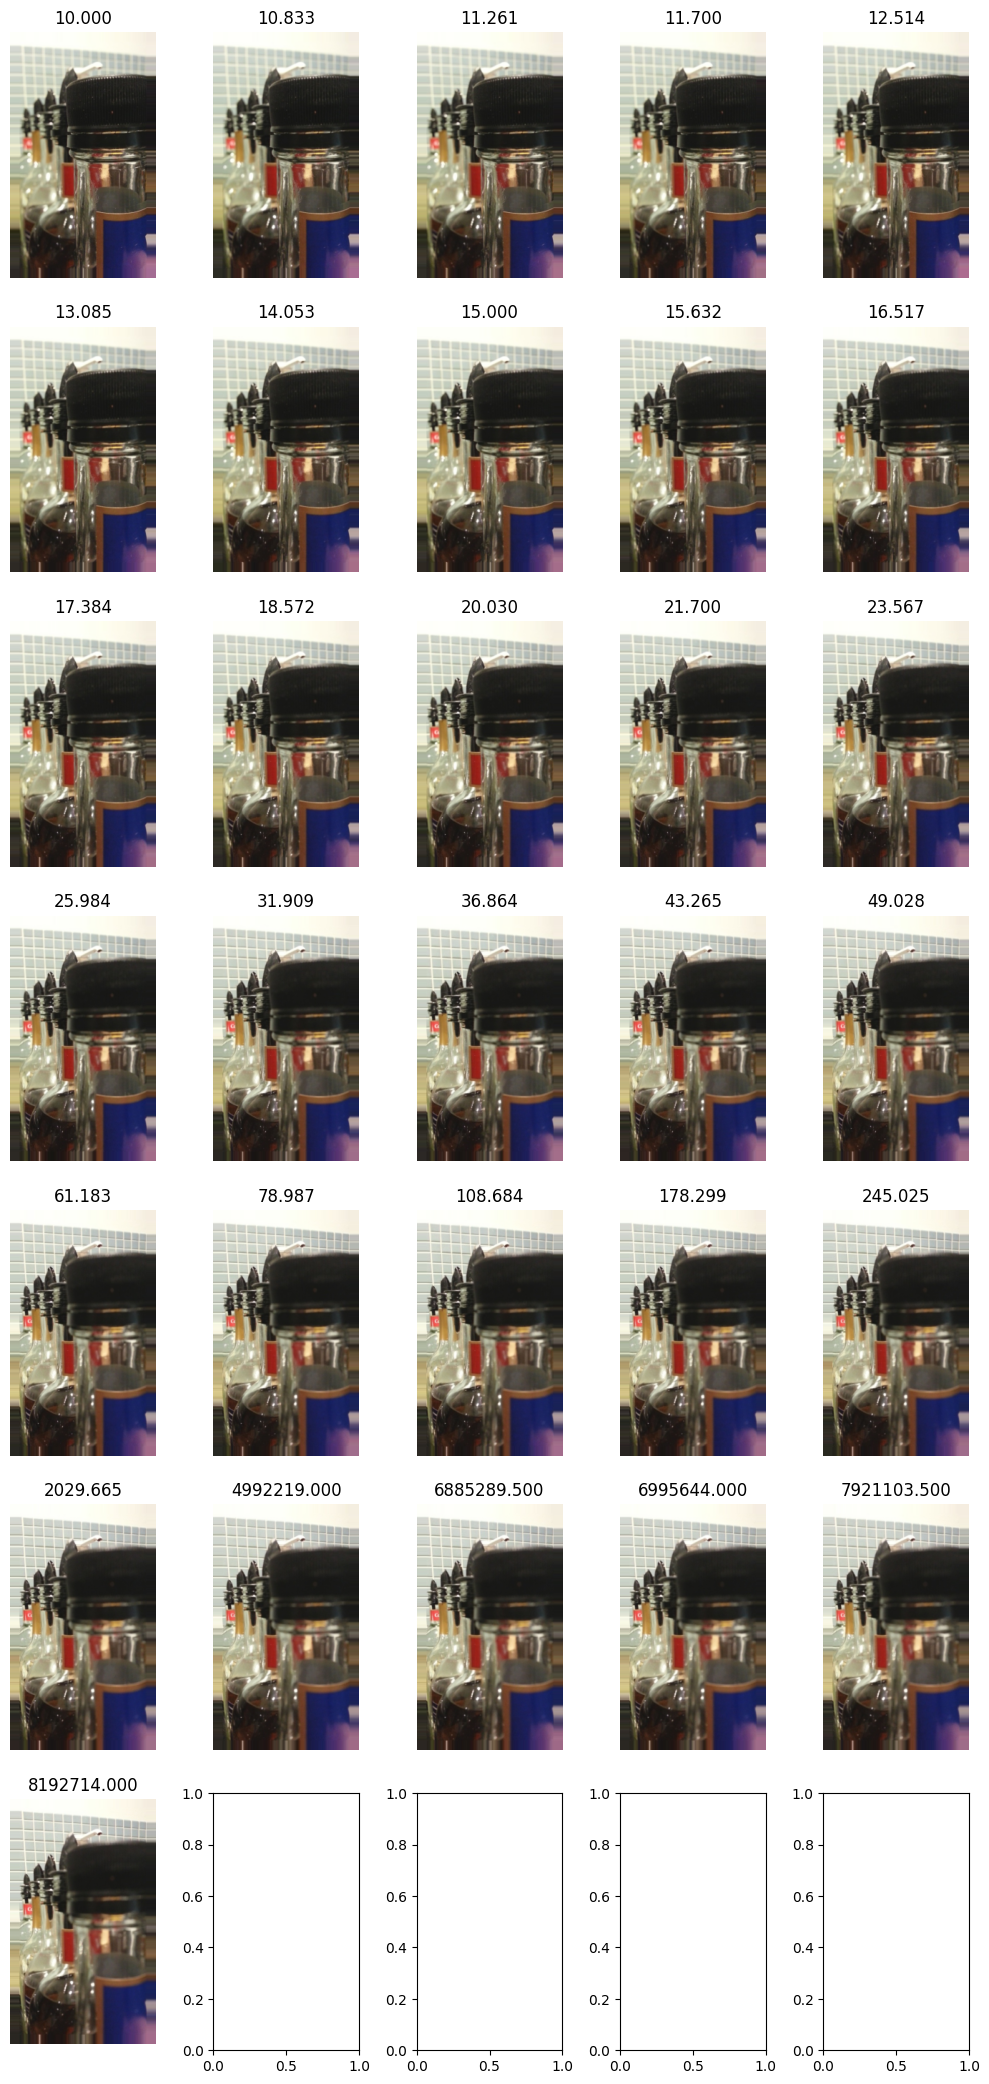

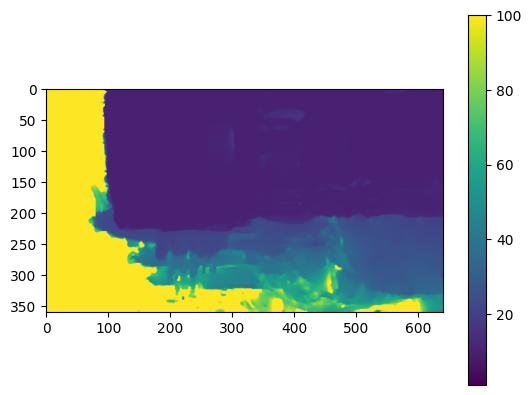

adaptive kernel size set to 11


In [42]:
globals.init_MobileDepth()

IMAGE_RANGE = 255.
example_name = "bottles"
# ["keyboard", "bottles", "fruits", "metals", "plants", "telephone", "window", "largemotion", "smallmotion", "zeromotion", "balls"]:

defocus_stack, dpt_result, scale_mat = utils.load_single_sample_MobileDepth(example_name)

globals.window_size = 25#30
rad = globals.window_size // 2

defocus_stack = np.stack([
    np.pad(np.rot90(
    skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=True)
        , k=-1),
           ((rad, rad), (rad, rad), (0, 0)), mode='edge')
    for img in defocus_stack
], axis=0)

defocus_stack *= IMAGE_RANGE 

# idx = sorted(np.random.choice(defocus_stack.shape[0], size=5, replace=False))
# defocus_stack = defocus_stack[idx]

print(defocus_stack.shape, defocus_stack.min(), defocus_stack.max())


order = np.argsort(globals.Df)

# apply sorting
globals.Df = globals.Df[order]
defocus_stack = defocus_stack[order]

globals.thresh = 0.1#.1
globals.ps = 0.75 * 2

# globals.ps = 1.2e-5 / 2#1#1.5
# globals.f = 3.7e-3
# globals.D = globals.f / 2.6

# globals.f = 50*1e-3
# globals.D = globals.f / 24
# globals.ps =5.6e-6

# idx = np.linspace(0, len(globals.Df) - 1, 5).astype(int)
# globals.Df = globals.Df[idx]
# defocus_stack = defocus_stack[idx]
# # globals.Df = np.array([0.25, 0.5, 0.75, 1, 1.25], dtype=np.float32)
# globals.Df = np.array([[.3, .45, .75, 1.2, 1.8], dtype=np.float32)


fs, width, height, _ = defocus_stack.shape
print(fs, width, height)
print(dpt_result.dtype, defocus_stack.dtype)

globals.min_Z = 1#max(0.1, globals.Df.min() - 3)
globals.max_Z = 100#min(max(width, height)*5, globals.Df.max() + 3)
# print('Depth range:', globals.min_Z,'-', globals.max_Z)
print('Dpt result range:', dpt_result.min(), '-',dpt_result.max())

plt.imshow(dpt_result, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()



utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

# plt.imshow(scale_mat)
# plt.colorbar()
# plt.show()

plt.imshow(dpt_result, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

# print(scale_mat.shape)
# print(scale_mat)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)


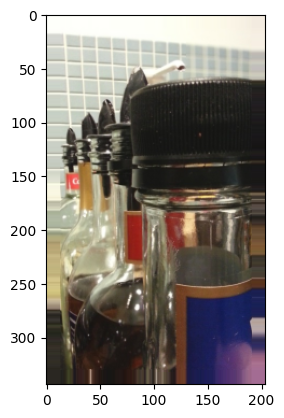

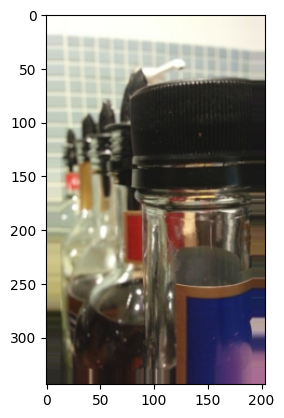

In [43]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [44]:
# from tqdm import tqdm
# mses = []
# for ps in tqdm(np.arange(0.1, 100, 1)):
#     utils.update_max_kernel_size(k)


dpt_result_resized = np.pad(
        np.rot90(
                skimage.transform.resize(dpt_result, (dpt_result.shape[0] // 2, dpt_result.shape[1] // 2), anti_aliasing=True),
            k=-1),
    rad, mode = 'edge')
defocus_stack_pred = forward_model.forward(dpt_result_resized, aif_init)


mse = np.mean((defocus_stack / IMAGE_RANGE - defocus_stack_pred / IMAGE_RANGE)**2)
# mses.append(mse)
print(mse)



precomputing indices
0.00083252456


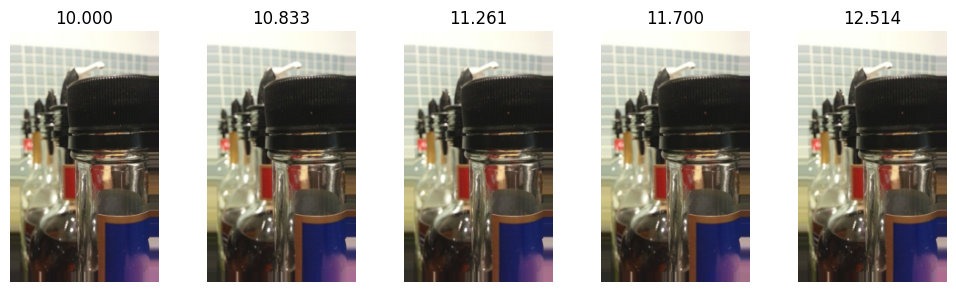

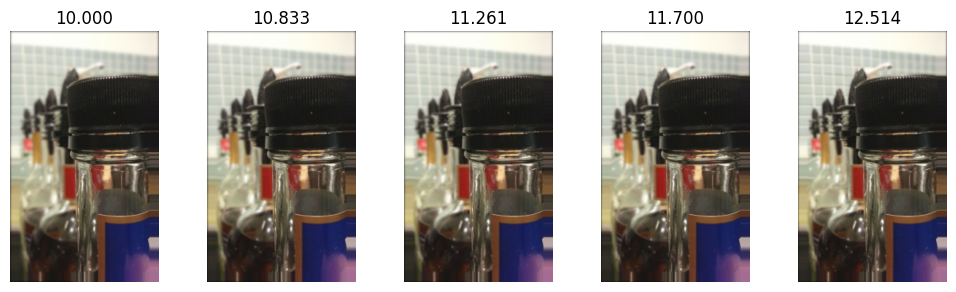

In [45]:
utils.plot_single_stack(defocus_stack[:5] / IMAGE_RANGE, globals.Df[:5])
utils.plot_single_stack(defocus_stack_pred[:5] / IMAGE_RANGE, globals.Df[:5])


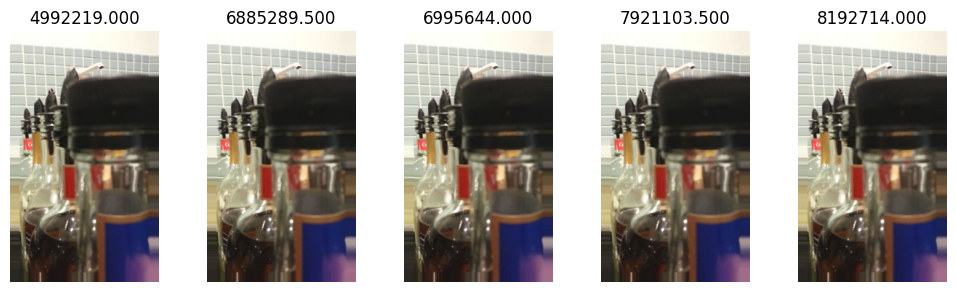

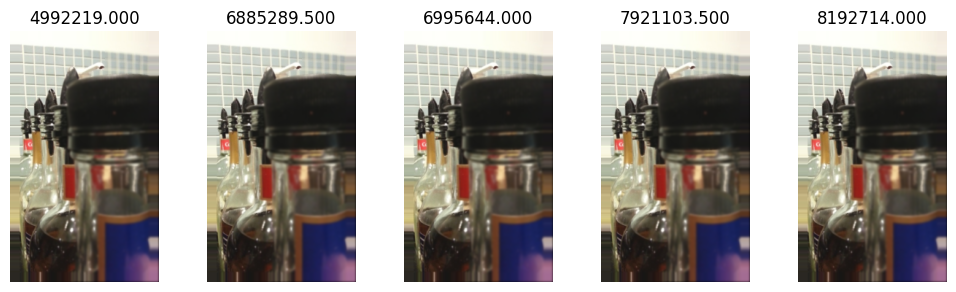

In [46]:
utils.plot_single_stack(defocus_stack[-5:] / IMAGE_RANGE, globals.Df[-5:])
utils.plot_single_stack(defocus_stack_pred[-5:] / IMAGE_RANGE, globals.Df[-5:])


In [ ]:
# vals = np.arange(0.1, 100, 1)#np.arange(0.1, 5 + 1e-6, 0.1)
# order = np.argsort(mses)

# order = sorted(range(len(mses)), key=lambda i: mses[i])

# mses_sorted = [mses[i] for i in order]
# vals_sorted = [vals[i] for i in order] 

# print(vals_sorted)
# print(mses_sorted)

In [25]:
# -------------------
# COORDINATE DESCENT
# -------------------

dpt, aif, _, experiment_folder = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=False, save_plots=True, num_epochs = 5,
        experiment_name = 'mobile-depth-keyboard-window5-grid',
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 10, ls_maxiter_multiplier = 2, 
        min_Z = globals.min_Z, max_Z = globals.max_Z,
        vmin = globals.min_Z, vmax = globals.max_Z, verbose = True,
        windowed_mse = True, test=True)

# Save uncropped and crop later bc this will help wth remove outliers 
utils.save_dpt_npy(experiment_folder, 'dpt', dpt)#[rad:-rad, rad:-rad])
utils.save_aif(experiment_folder, 'aif', aif)#[rad:-rad, rad:-rad, :])


Created experiment folder: /data/holly_jackson/experiments/mobile-depth-keyboard-window5-grid_2025-11-12_23-16-05
Images in range [0-255]
precomputing indices
Iteration 0 



Grid search         : 100%|███████████████████| 200/200 [01:55<00:00,  1.73it/s]


GRID SEARCH DURATION 115.65389680862427

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 211.83346462249756
Loss: 32.78001 , TV: 425413.25

DPT result range: [ 1.0047629 , 799.77234 ]


Bounded FISTA...


Optimizing: 100%|███████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]


r1norm 11556.432 norm(x) 61615.113
FISTA duration 71.60168433189392

AIF result range: [ 9.294659 , 255.0 ]
Loss: 20.449179 , TV: 2677552.0
FULL ITER DURATION 413.7022547721863
ls_maxiter updated to 20


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 200/200 [02:00<00:00,  1.66it/s]


GRID SEARCH DURATION 121.15864777565002

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 231.50394463539124
Loss: 19.36698 , TV: 733835.5

DPT result range: [ 1.0047629 , 799.95874 ]


Bounded FISTA...


Optimizing: 100%|███████████████████████████████████████| 20/20 [01:20<00:00,  4.01s/it]


r1norm 11109.061 norm(x) 61664.906
FISTA duration 112.38390898704529

AIF result range: [ 2.3576431 , 255.0 ]
Loss: 18.911217 , TV: 2765195.2
FULL ITER DURATION 479.86564683914185
ls_maxiter updated to 40


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 200/200 [02:00<00:00,  1.65it/s]


GRID SEARCH DURATION 121.27817440032959

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 230.30279970169067
Loss: 18.773619 , TV: 880610.7

DPT result range: [ 1.0047629 , 799.9789 ]


Bounded FISTA...


Optimizing: 100%|███████████████████████████████████████| 40/40 [02:41<00:00,  4.03s/it]


r1norm 11035.134 norm(x) 61697.285
FISTA duration 193.67390203475952

AIF result range: [ 0.0 , 255.0 ]
Loss: 18.661171 , TV: 2885857.0
FULL ITER DURATION 560.4393966197968
ls_maxiter updated to 80


--------------------------

Iteration 3 



Grid search         :  80%|███████████████    | 159/200 [01:36<00:24,  1.64it/s]


KeyboardInterrupt: 


KeyboardInterrupt



In [ ]:
# # print final MSE based on cropped result
# pred_cropped = forward_model.forward(dpt[rad:-rad, rad:-rad], aif[rad:-rad, rad:-rad, :])
# gt_cropped = defocus_stack[:, rad:-rad, rad:-rad, :]
# print('Final cropped MSE:', coordinate_descent.mse_loss(pred_cropped, gt_cropped))

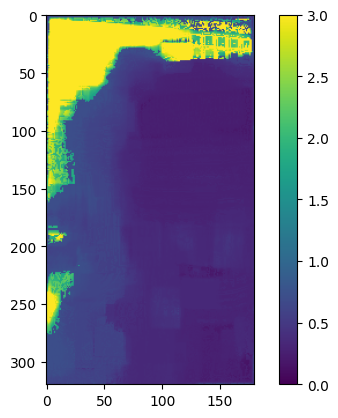

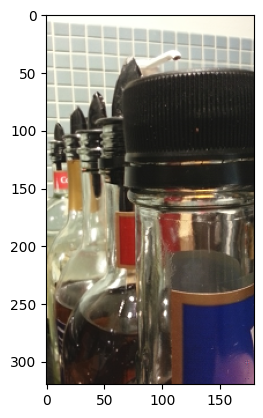

Removing outliers...
found 0 outliers


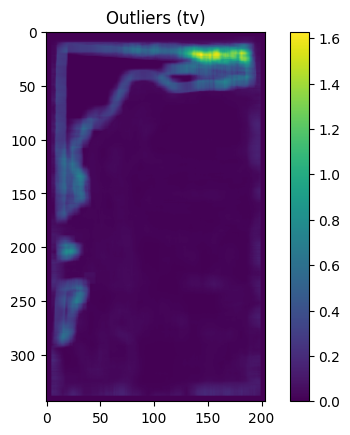

0 / 0 outliers removed


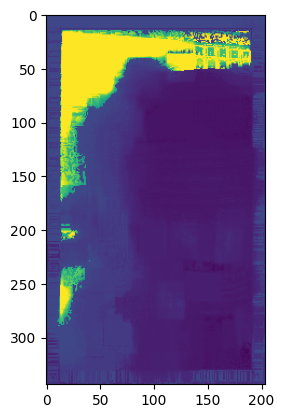

0.01 3


In [62]:
# experiment_folder = '/data/holly_jackson/experiments/mobile-depth-keyboard-window5-grid_2025-11-08_15-15-12'
# dpt = utils.load_dpt_npy(experiment_folder, 'dpt')
# aif = utils.load_aif(experiment_folder, 'aif')

# utils.plot_compare_greyscale(dpt, dpt_result_resized, vmin=globals.min_Z, vmax=globals.max_Z)
plt.imshow(dpt[rad:-rad, rad:-rad], vmin=0, vmax=3)
plt.colorbar()
plt.show()

plt.imshow(aif[rad:-rad, rad:-rad] / IMAGE_RANGE)
plt.show()

dpt_new, _ = section_search.remove_outliers(dpt.copy(), aif, patch_type = 'tv', tv_thresh = 25, to_plot=True)

plt.imshow(dpt_new, vmin=0.1, vmax=3)
plt.show()
print(globals.min_Z, globals.max_Z)

In [ ]:
worst_coords = utils.get_worst_diff_pixels(dpt, dpt_result_resized, num_worst_pixels=10, vmin=globals.min_Z, vmax=globals.max_Z)

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - dpt_result_resized)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [ ]:
globals.thresh = 0.5
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

In [ ]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

In [ ]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=dpt_result_resized,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=dpt_result_resized,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])